In [48]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import zipfile
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label

In [2]:
np.random.seed(43)

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
UNZIP_PATH ="/content/drive/MyDrive/data-science-bowl-2018.zip"


In [5]:
# Unzip data
with zipfile.ZipFile(UNZIP_PATH , 'r') as zip_ref:
    zip_ref.extractall('./datasciencebowleee')

# with zipfile.ZipFile(UNZIP_PATH + 'stage1_test.zip', 'r') as zip_ref:
#     zip_ref.extractall('./test')

In [6]:
with zipfile.ZipFile("/content/datasciencebowleee/stage1_train.zip" , 'r') as zip_ref:
    zip_ref.extractall('./trainhere')

In [7]:
with zipfile.ZipFile("/content/datasciencebowleee/stage1_test.zip" , 'r') as zip_ref:
    zip_ref.extractall('./testhere')

In [8]:
train_ids = next(os.walk('./trainhere'))[1]
test_ids = next(os.walk('./testhere'))[1]

In [9]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_CHANNEL=3

In [10]:
X_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=bool)

In [49]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)

    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [50]:
inputs=layers.Input((IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNEL))

In [51]:
s=layers.Lambda(lambda x:x/255)(inputs)

In [52]:
c1=layers.Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(s)
c1=layers.Dropout(0.1)(c1)
c1=layers.Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c1)
p1=layers.MaxPooling2D((2,2))(c1)

In [53]:
c2=layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p1)
c2=layers.Dropout(0.1)(c2)
c2=layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c2)
p2=layers.MaxPooling2D((2,2))(c2)

In [54]:
c3=layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p2)
c3=layers.Dropout(0.1)(c3)
c3=layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c3)
p3=layers.MaxPooling2D((2,2))(c3)

In [55]:
c4=layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p3)
c4=layers.Dropout(0.1)(c4)
c4=layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c4)
p4=layers.MaxPooling2D((2,2))(c4)

In [56]:
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

###**Expanding path**###

In [57]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

In [58]:
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_2 (Lambda)              (None, 128, 128, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_39 (Conv2D)             (None, 128, 128, 16  448         ['lambda_2[0][0]']               
                                )                                                                 
                                                                                            

In [45]:
TRAIN_PATH='./trainhere/'
TEST_PATH='./testhere/'

In [21]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMAGE_CHANNEL]
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    Y_train[n] = mask

Resizing training images and masks


100%|██████████| 670/670 [04:52<00:00,  2.29it/s]


In [22]:
X_test = np.zeros((len(test_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL), dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMAGE_CHANNEL]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Resizing test images


100%|██████████| 65/65 [00:01<00:00, 37.64it/s]

Done!


In [59]:
import random

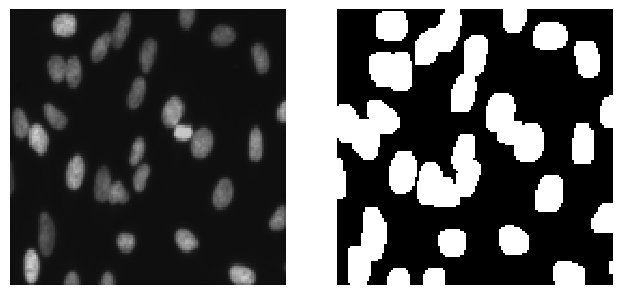

In [60]:
plt.subplot(1,2,1)
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.axis("off")
plt.subplot(1,2,2)
imshow(np.squeeze(Y_train[image_x]))
plt.axis("off")
plt.show()

In [62]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=7, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir="logs/", histogram_freq=1)]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=callbacks)

Epoch 1/50
38/38 [==============================] - 7s 177ms/step - loss: 0.1425 - my_iou_metric: 0.4264 - val_loss: 0.1422 - val_my_iou_metric: 0.4534
Epoch 2/50
38/38 [==============================] - 6s 155ms/step - loss: 0.1304 - my_iou_metric: 0.4457 - val_loss: 0.1155 - val_my_iou_metric: 0.4520
Epoch 3/50
38/38 [==============================] - 7s 182ms/step - loss: 0.1190 - my_iou_metric: 0.4691 - val_loss: 0.1071 - val_my_iou_metric: 0.4357
Epoch 4/50
38/38 [==============================] - 6s 149ms/step - loss: 0.1189 - my_iou_metric: 0.4690 - val_loss: 0.1102 - val_my_iou_metric: 0.4542
Epoch 5/50
38/38 [==============================] - 7s 182ms/step - loss: 0.1109 - my_iou_metric: 0.4881 - val_loss: 0.1025 - val_my_iou_metric: 0.4732
Epoch 6/50
38/38 [==============================] - 6s 156ms/step - loss: 0.1125 - my_iou_metric: 0.4871 - val_loss: 0.0961 - val_my_iou_metric: 0.5049
Epoch 7/50
38/38 [==============================] - 7s 176ms/step - loss: 0.1075 - my_io

In [67]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 0s 12ms/step


/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


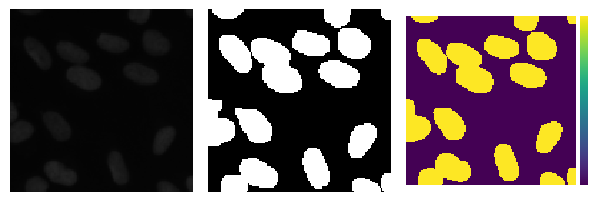

In [68]:
ix = random.randint(0, len(preds_train_t))
plt.subplot(1,3,1)
imshow(X_train[ix])
plt.axis("off")
plt.subplot(1,3,2)
imshow(np.squeeze(Y_train[ix]))
plt.axis("off")
plt.subplot(1,3,3)
plt.axis("off")
imshow(np.squeeze(preds_train_t[ix]))
plt.axis("off")
plt.show()

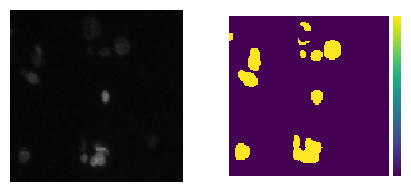

In [69]:
ix = random.randint(0, len(preds_test_t))
plt.subplot(1,3,1)
imshow(X_test[ix])
plt.axis("off")
plt.subplot(1,3,2)
plt.axis("off")
imshow(np.squeeze(preds_test_t[ix]))
plt.axis("off")
plt.show()